# Explanation on accompanying code

This notebook explains the different functions I implemented and demonstrates how they are intended to be used.

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# import code
from plotting import plotting
from riemann import riemann

In [2]:
# initialize

mu = 1.0 # set to 1 for convenience
T = 1.0 # set to 1 for convenience

# choose some initial conditions
rho_L = 1.  # x < 0
rho_R = 1.  # x > 0

v_L = 1
v_R = 0.

# insert momentum in state space vector
U_L = (rho_L, v_L*rho_L)
U_R = (rho_R, v_R*rho_R)

# Initialize plotting class
plots = plotting(rho_L, rho_R, v_L, v_R)

## Plotting class
This class is equipped with the following functions:
- `plot_Hugoniot_locus`: curves for 1 initial state
- `plot_Hugoniot_locus_derivative`: curves for 1 initial state with derivatives in intersection point
- `plot_integral_curves`: curves for 1 initial state
- `plot_integral_hugoniot`: integral curves and hugoniot loci compared
- `plot_numerical_solution`: plot numerical solution for given method
- `plot_numerical_state_space`: plot numerical solution on state space instead of momentum and density profile on space for final time
- `Plot_Rankine_hugoniot`: plot Hugoniot loci and shock speed for 1 initial state
- `Plot_Rankine_hugoniot_derivative`: add derivative to the previous function
- `plot_2_hugoniot_loci`: plot hugoniot loci for 2 initial states + intermediate state
- `full_solution`: decide on evolution for left and righ state and create plot 


### Plot Hugoniot loci and integral curves

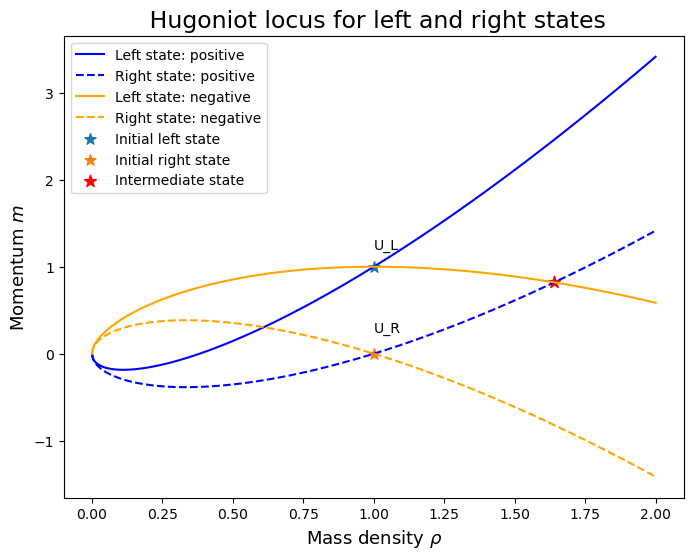

In [3]:
# plot hugoniot locus for left and right states
plots.plot_2_hugoniot_loci(U_L, U_R, intermediate=True)

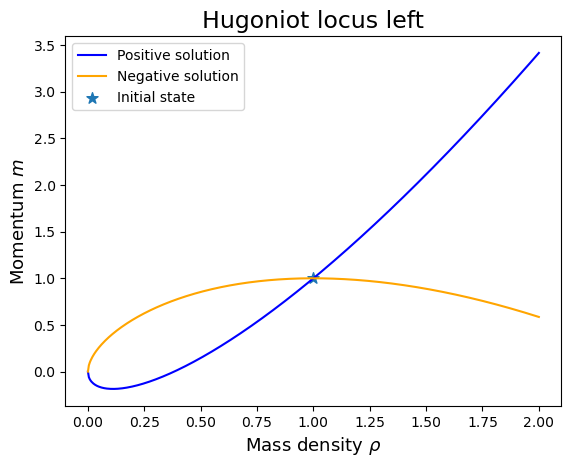

In [4]:
# we plot the Hugoniot locus for a given state U
title = "Hugoniot locus left"
plots.plot_Hugoniot_locus(U_L, title=title)

/Users/bertdepoorter/Nextcloud/Documents/School/Universiteit/CmpMethothods Astrophysics/Individual_CMfAA/riemann.py:125: RuntimeWarning: divide by zero encountered in log
  m = v_hat*rho_range - self.c_s * rho_range * np.log(rho_range / rho_hat)
/Users/bertdepoorter/Nextcloud/Documents/School/Universiteit/CmpMethothods Astrophysics/Individual_CMfAA/riemann.py:125: RuntimeWarning: invalid value encountered in multiply
  m = v_hat*rho_range - self.c_s * rho_range * np.log(rho_range / rho_hat)
/Users/bertdepoorter/Nextcloud/Documents/School/Universiteit/CmpMethothods Astrophysics/Individual_CMfAA/riemann.py:127: RuntimeWarning: divide by zero encountered in log
  m = v_hat*rho_range + self.c_s * rho_range * np.log(rho_range / rho_hat)
/Users/bertdepoorter/Nextcloud/Documents/School/Universiteit/CmpMethothods Astrophysics/Individual_CMfAA/riemann.py:127: RuntimeWarning: invalid value encountered in multiply
  m = v_hat*rho_range + self.c_s * rho_range * np.log(rho_range / rho_hat)


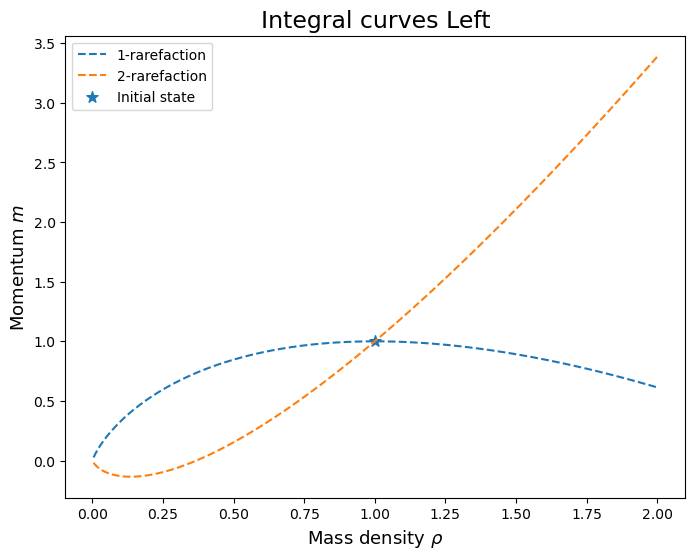

In [5]:
# plot integral curves for left state
plots.plot_integral_curves(U_L, title='Integral curves Left')

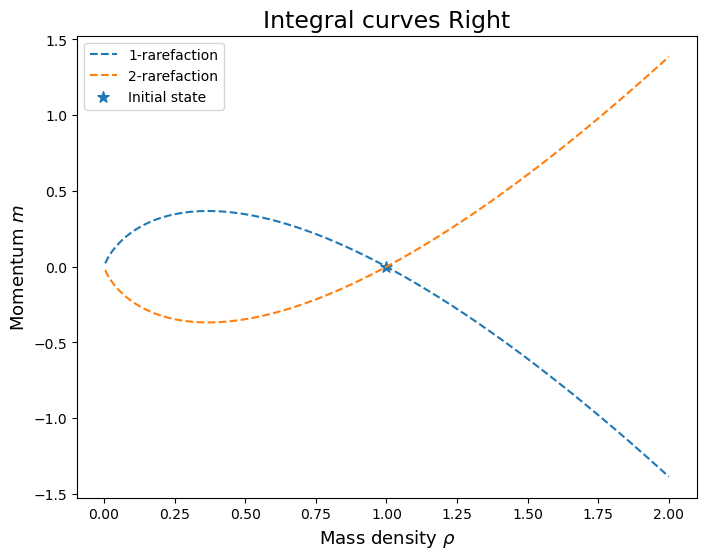

In [6]:
# Plot integral curves for right state
plots.plot_integral_curves(U_R, title='Integral curves Right')

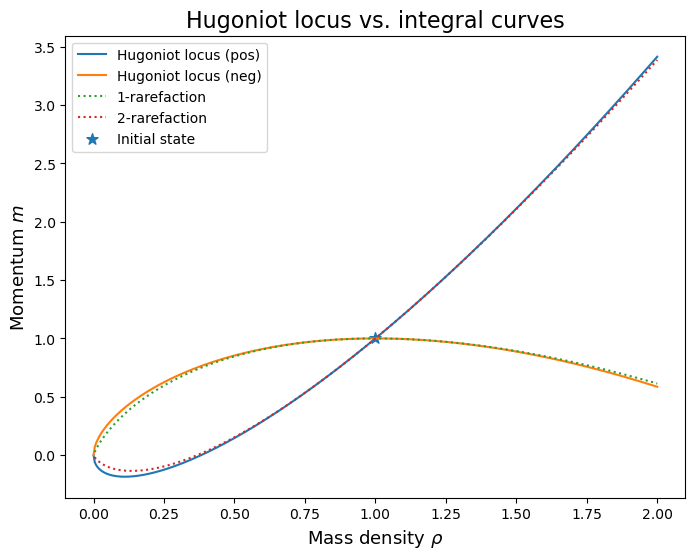

In [7]:
# Plot both Hugoniot loci and integral curves
plots.plot_integral_hugoniot(np.array([1,1]), title='Hugoniot locus vs. integral curves',
                   name='integral_hugoniot')

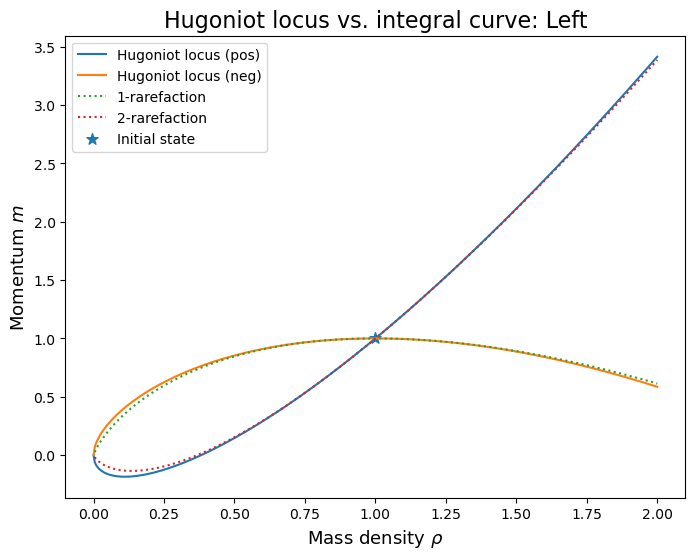

In [8]:
# Plot both Hugoniot loci and integral curve for left state
plots.plot_integral_hugoniot(U_L, 
                             title='Hugoniot locus vs. integral curve: Left',
                             name='Hugoniot_integral_left')

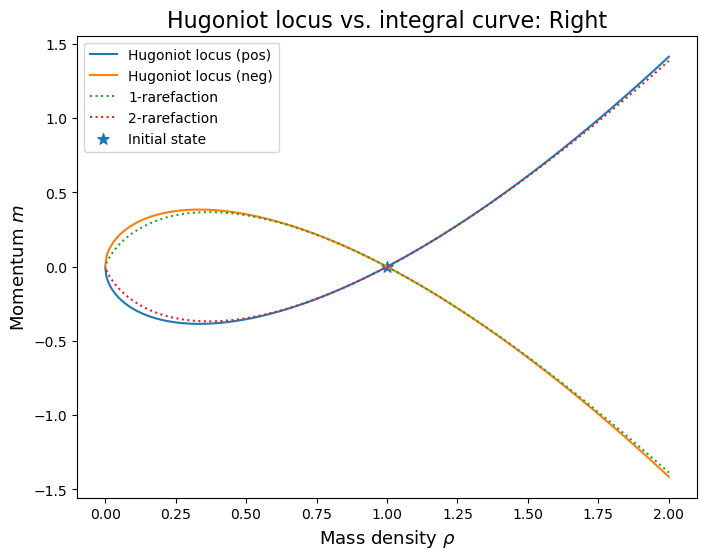

In [9]:
# Plot both Hugoniot loci and integral curve for right state
plots.plot_integral_hugoniot(U_R, 
                             title='Hugoniot locus vs. integral curve: Right',
                             name='Hugoniot_integral_right')

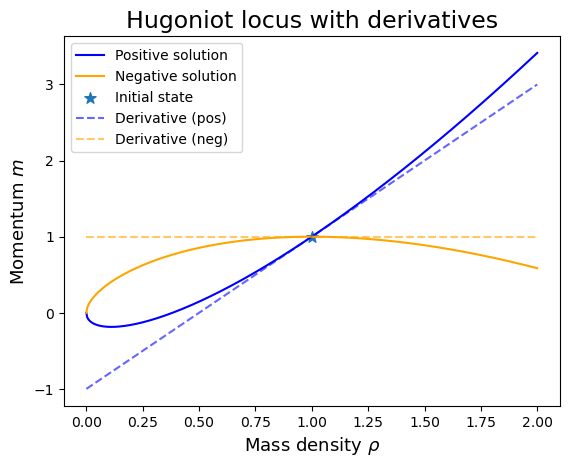

In [10]:
# Plot the derivatives on the Hugoniot loci for left state
plots.plot_Hugoniot_locus_derivative(U_L,
                                    name='Hugoniot_curve_left')

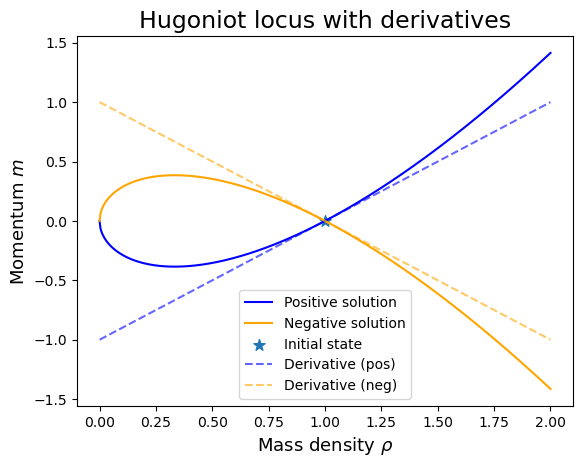

In [11]:
# Plot the derivatives on the Hugoniot loci for right state
plots.plot_Hugoniot_locus_derivative(U_R,
                                    name='Hugoniot_curve_right')

In [ ]:
# Plot momentum and shock speed parametrized for left state
plots.Plot_Rankine_hugoniot_derivative(U_L,
                                      name='Hugoniot_rankine_derivative_left')

In [ ]:
# Plot momentum and shock speed parametrized for right state
plots.Plot_Rankine_hugoniot_derivative(U_R,
                                      name='Hugoniot_rankine_derivative_right')

### Run tests of notes

In this part we run the tests that are also done in the lecture notes. We find similar results. 

In [ ]:
def solve(rho_L, rho_R, v_L, v_R, name):
    plots = plotting(rho_L, rho_R, v_L, v_R)
    plots.full_solution(name=name)

In [ ]:
# test for syntax errors
solve(1,1,1, 0.5, 'test_syntax')

In [ ]:
# test 1

solve(1, 0.125, 0, 0, 'test1_statespace')

In [ ]:
# test 2
solve(0.445, 0.5, 0.31061/0.445, 0, 'test2_statespace')

In [ ]:
# Test 3
solve(0.5, 0.445, 0, 0.31061/0.445, 'test3_statespace')

### Plotting numerical solution

In [ ]:
# numerical solution for tvdlf, minmod limiter and twostep scheme
plots.plot_numerical_solution('tvdlf', 
                              'minmod', 
                              'twostep',
                              nx=100, 
                              t_end=0.06
                            )

In [ ]:
# test maccormack scheme
plots.plot_numerical_solution('maccormack', 
                              'minmod', 
                              'twostep',
                              nx=100, 
                              t_end=0.004
                            )

In [ ]:
# test upwind scheme
plots.plot_numerical_solution('upwind', 
                              'minmod', 
                              'twostep',
                              nx=100, 
                              t_end=0.06
                            )

Here we test the nuerical solution for the three test cases. 

In [ ]:
# test 1
rho_L = 1
m_L = 0 

rho_R = 0.125
m_R = 0

v_L = m_L/rho_L
v_R = m_R/rho_R

# Initialize class with correct numbers
test1 = plotting(rho_L, rho_R, v_L, v_R)

# Run
test1.plot_numerical_solution('tvdlf',
                             'minmod',
                              'twostep',
                              t_end=0.05
                             )

We see that for $t=0.15$, the self-implemented numerical solutions do not give satisfactory results. This is probably due to a simplistic implementation, without taking care of some subtleties